# Regression Related Evaluation Metrics

Regression problems are the problems where we try to make a prediction on a continuous scale. This chapter aims to help develop (or rediscover) the intuition behind some of these popular metrics, namely $R^2$, for evaluating regression models. Using an open source housing dataset, we first build three different models and thereafter intutitively build various metrics that help evaluate the the performance of the three trained models against each other. We start with basic evaluation metrics such as error, absolute error, etc and eventually try to the build the underlying intutition behind $R^2$. 

## Predicting House Price

Let's assume we are tasked to build a model that can predict house prices. Further, we are provided with an open source Boston city dataset. As shown in the code snippet below, we can load the dataset as a `pandas` dataframe. In the table below, "price" is the variable we aim to predict and treat the rest of the variables as input features. You can find more information about the individual fields in the dataset over [here](https://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.names).

In [1]:
from sklearn import datasets
import pandas as pd
import warnings
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")
warnings.simplefilter(action='ignore', category=FutureWarning)


boston = datasets.load_boston()
data = pd.DataFrame(boston.data, columns=boston.feature_names)
data['price'] = boston.target
data.sample(n=5)


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,price
354,0.04301,80.0,1.91,0.0,0.413,5.663,21.9,10.5857,4.0,334.0,22.0,382.80,8.05,18.2
294,0.08199,0.0,13.92,0.0,0.437,6.009,42.3,5.5027,4.0,289.0,16.0,396.90,10.40,21.7
192,0.08664,45.0,3.44,0.0,0.437,7.178,26.3,6.4798,5.0,398.0,15.2,390.49,2.87,36.4
255,0.03548,80.0,3.64,0.0,0.392,5.876,19.1,9.2203,1.0,315.0,16.4,395.18,9.25,20.9
110,0.10793,0.0,8.56,0.0,0.520,6.195,54.4,2.7778,5.0,384.0,20.9,393.49,13.00,21.7


We randomly split the data into 80/20 i.e 80% data is used for training and 20% of the data is used for testing. Further, let's assume that we train three different models to predict house prices. The three models we will train are:

1. **Mean Model:** Assume that the only available information is prices of adjoining houses to your house. Now, if someone asks what's the price of a nearby house, one is likely to guess a value close to the "mean" house price of the adjoining houses. It can be shown that when no information is available other than the target variable, using the expected value (or "mean") of the target variable as the predicted value will minimize the total absolute error. Here, I use the term "mean model" to describe such a model. For every data point, "Mean model" returns a constant value equal to the observed mean value of the target variable in the training dataset. 
 As you will see later, this model serves as a great baseline for evaluating other models. 

2. **Linear Regression Model:** The second model will use linear regression algorithm. Linear regression and its variants (such as Lasso, ElasticNet, etc) are one of the most popular algorithms to deal with regression problems. For the purpose of this chapter, we will use the ordinary least square algorithm. 

3. **Xgboost:** The third model is based on the "Xgboost" algorithm. Xgboost trains multiple decision trees where each tree increases the weight depending on the error observed in the previous tree. 

For the purpose of this chapter, it's not important to understand how these different algorithms work. The only motivation for training three different models is to help conceptualize and develop an evaluation metric that allows us to compare different models and determine the best. In the same spirit, we also skip feature engineering and hyper-parameter tunning. These steps are critical to building a good quality model. But the focus of this chapter is not to build the best model for house price prediction but on how to evaluate regression models. 

Using training data, below code snippt trains the three models and use the same to predict house price for the houses in our test dataset. 

In [2]:
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor

# Split Data Into Training and Test Dataset 
# so that we use the same training and test dataset 
# to train and test three models. Also setting random state 
# so that we can results are reproducible
import numpy as np
train, test = train_test_split(data, test_size=0.2, random_state=10)
train.is_copy = None
test.is_copy = None
print("Training Dataset: ", train.shape)
print("Test Dataset: ", test.shape)

# =====================
# TRAIN MODELS
# =====================

# Mean Model
# It simply returns mean value based on the training dataset 
# as a prediction. Fixing 
mean_model = DummyRegressor(strategy='mean')
mean_model.fit(train[boston.feature_names], train['price'])

# Linear Regression
median_model = LinearRegression(normalize=True)
median_model.fit(train[boston.feature_names], train['price'])

# xgboost model
xgboost_model = XGBRegressor()
xgboost_model.fit(train[boston.feature_names], train['price'])

# =====================
# GENERATE PREDICTIONS
# =====================
test['mean'] = mean_model.predict(test[boston.feature_names])
test['regression'] = median_model.predict(test[boston.feature_names])
test['xgboost'] = xgboost_model.predict(test[boston.feature_names])

## display results
test[['price', 'mean', 'regression', 'xgboost']].sample(5)

Training Dataset:  (404, 14)
Test Dataset:  (102, 14)
[23:30:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


,price,mean,regression,xgboost
65,23.5,21.841832,30.873149,26.025826
107,20.4,21.841832,21.243959,20.909090
311,22.1,21.841832,26.982815,23.956749
119,19.3,21.841832,20.880395,21.371815
486,19.1,21.841832,19.676509,17.655367


## Error Distribution and Mean Absolute Error

The next challenge is determining the best model of the three or to rank order them based on the quality. However, quality is undefined and we need to define it. The first thing that comes to mind is to examine error i.e. difference between actual house price and the predicted value. Note that the error can be positive if the model underpredicts the value of a given house or vice-versa. Since there are hundreds of houses in the test dataset, as shown in the below plot, we can further examine the distribution of error for each model. 

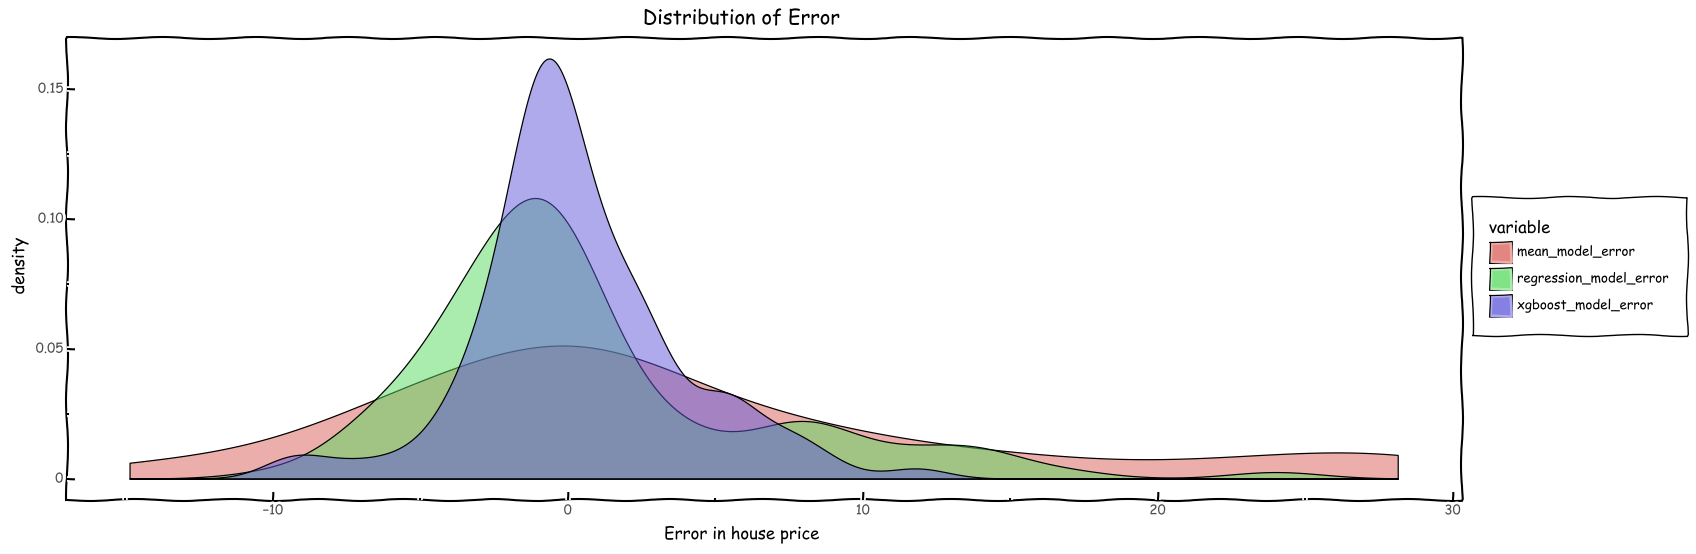

<ggplot: (305548849)>

In [4]:
# =====================
# CALCULATE ERROR
# =====================
test['mean_model_error'] = test['price'] - test['mean']
test['regression_model_error'] = test['price'] - test['regression']
test['xgboost_model_error'] = test['price'] - test['xgboost']

# =====================
# PLOT DISTRIBUTION OF ERRORS
# FOR THREE MODELS
# =====================

# convert wide format to row format so that it
# easy to visualize and compute statistical properties
errorDF = test.melt(value_vars=['mean_model_error', 'regression_model_error', 'xgboost_model_error']) 

%matplotlib inline
from plotnine import *
display(
    ggplot(errorDF, aes('value', fill='variable')) 
    + geom_density(alpha=0.5) 
    + theme_xkcd()
    + theme(figure_size=(18,6))
    + xlab("Error in house price")
    + ggtitle("Distribution of Error")
)



The distribution of error tells a lot about each model. For instance, from the above plot, we can examine that xgboost based model has a much smaller standard deviation as compared to other models. But as an evaluation metric, we desire for a single real number that makes comparing and ranking competing models easier.  Unless there is a significant bias in the model, the error is normally distributed (and as we can observe from the above plot). A normal distribution can be described using two parameters: mean and standard deviation. Thus one option to convert the distribution to a single number that serves as an evaluation criterion is to examine mean error for each model and we can name this evaluation criteria as "mean error". The code snippet below computes the mean and standard deviation for error distribution associated with each model. 

In [5]:

# =====================
# CALCULATE MEAN AND SD
# =====================
print("Mean and Standard Deviation")
display(
    errorDF
    .groupby('variable').agg({'value': ['mean', 'std']})
    .reset_index()
    .sort_values(('value', 'mean'))
)

Mean and Standard Deviation


variable     value           
                               mean        std
2     xgboost_model_error  0.315741   3.499984
1  regression_model_error  0.739362   5.848302
0        mean_model_error  3.427776  10.276974

Using "mean error" as an evaluation criterion we can conclude that xgboost based model has the smallest error as compared to other models. However, there is an obvious flaw in our conclusion.  Let's assume that we have a model, say Model X, that always over predict i.e. the error is always negative. In this case, the mean error will be negative and let's assume it's -3. Since -3 is less than the mean error of the xgboost based model, we might wrongly conclude that Model X is better than the xgboost based model.

One might jump to fix the problem by taking absolute of mean error as it will again restore xgboost based model as the best quality model. There is, however, another issue. Assume that there are two houses in our test dataset and a model underestimate one by 10K, i.e. error = 10K, and overestimate the other by 10K, i.e error = -10K. Here, the mean error and absolute mean error will be zero. This model should be the best model we can as the absolute mean error can never be less than zero.  However, this doesn't make sense. 

The problem with absolute mean error is that the individual errors are not additive. To make the errors additive we can take absolute error and thereafter take the mean of absolute error. Thus in the above example, the mean absolute error will be $ \frac{|-10| + |10|}{2} = 10$. Note that there is a significant difference between "absolute mean error" and our new evaluation metric "mean absolute error". In the former, we first compute mean and then apply absolute function. In the later, we first apply the absolute function to individual errors and thereafter take the mean. For obvious reasons, this new evaluation metric is referred as "Mean Absolute Error" or MAE. Mathematically MAE can be defined as:

$$MAE = \frac{\sum_{i=1}^{N}|\hat{y_i} - y_i|}{N}$$

Let's re-evaluate the quality of our three models using MAE.

In [6]:
# Conver error into absolute error
errorDF['absolute_error'] = errorDF['value'].abs()
display(
    errorDF
    .groupby('variable')
    .agg({'absolute_error': 'mean'})
    .reset_index()
    .rename(columns={'absolute_error': 'MAE'})
    .sort_values('MAE')
)

,variable,MAE
2,xgboost_model_error,2.492412
1,regression_model_error,4.061419
0,mean_model_error,7.554703


The unit of MAE is the same as that of the target variable. This makes MAE easy to understand and interpret. However, "mean" is one of the parameters several parameters related to a distribution and is sensitive to outliers. Hence, sometimes instead of taking the mean of absolute error, "median absolute error" is also reported. 

## $R^2$ 

While MAE and its variants are easy to interpret, they have one major shortcoming. These metrics focus on the centrality of the error distribution (i.e. mean or median) and ignore the spread of error. For instance, consider two house prediction models both having MAE of \$10K. However, for one of the model the error ranges from \$5K to \$15K and for another it can range from \$0K to \$50K. In this case,the first model might be more desirable due to its smaller spread. When trying to make a decision about which model is the best, dealing with two separate metrics independently is often challenging and hence one need a single metric that can take into account the whole distribution of errors rather than focusing on the centrality of the errror. 

In our search for a better metric, let's revisit some of the core questions we are trying to answer as part of our evaluation strategy. One question that's important is understanding what percentage of houses exhibit less than certain absolute error. We can easily answer this by plotting the cumulative distribution of absolute error as shown below. 

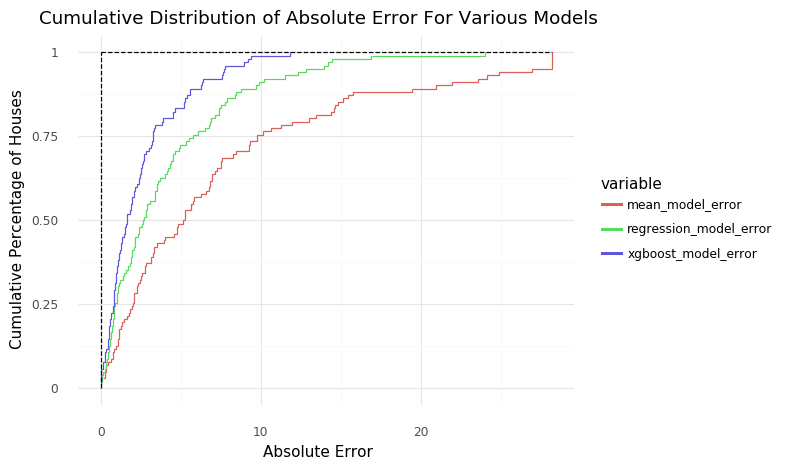

<ggplot: (307586665)>

In [7]:
# For now ignore this. The below description will help understand this eventually
idealModel = pd.DataFrame(
    [[0, 0, 0, 1.], [0, 1, np.max(errorDF.absolute_error), 1.]],
    columns=['x1', 'y1', 'x2', 'y2']
)

(
    ggplot() 
    
    # we use stat_ecdf function to compuate cumulative distribution and plot the same
    + stat_ecdf(aes('absolute_error', color='variable'), data=errorDF, geom='step')
    
    # plot the idea model
    + geom_segment(aes(x='x1', y='y1', xend='x2', yend='y2'), data=idealModel, linetype='dashed')
    
    # render labels
    + theme_minimal()
    + xlab("Absolute Error")
    + ylab("Cumulative Percentage of Houses")
    + ggtitle("Cumulative Distribution of Absolute Error For Various Models")
)

We can observe that for the xgboost based model, 95% of the houses have less than 10 unit of absolute error. Whereas only about 75% of houses have less than 10 unit of absolute error for the "mean model". 

One thing that also stands out in the above plot is the clear hierarchy of lines. As the model get's better, the closer it's moving towards the top left part of the plot. For instance, the xgboost based model, which is the best of the three based on MAE metric, is closest to the top left part of the plot. Similarly, the "mean model", which is the worst, is farthest from the top left point of the plot. There is a reason for such a behavior. Let's think about an ideal model. An ideal model will zero absolute error for 100% of the test cases. Shown by the black dotted line in the above plot, the cumulative distribution plot for this ideal model will overlap with y-axis and extend up to 1.  Thus, as our models will get better the closer they should move towards the cumulative distribution of the ideal model. 

We can further quantify the notion of "closeness" to the ideal model as the area between the ideal model and the cumulative distribution plot of a given model. Let's represent this area by $AAC$ or "area above curve$. **AAC reflects how far is a given model from the ideal model or the possible improvement opportunity**, For instance, in the below plot the red region indicates the AAC for the xgboost based model. Similarly, AAC of the "mean model" will be equal to green region plus red region. Mathematically, we can define AAC as:

$$ AAC(m) = \int_0^{1}{|y-\hat{y}_m|} ~ \approx ~ \sum_i{|y_i-\hat{y}_{m, i}|} $$

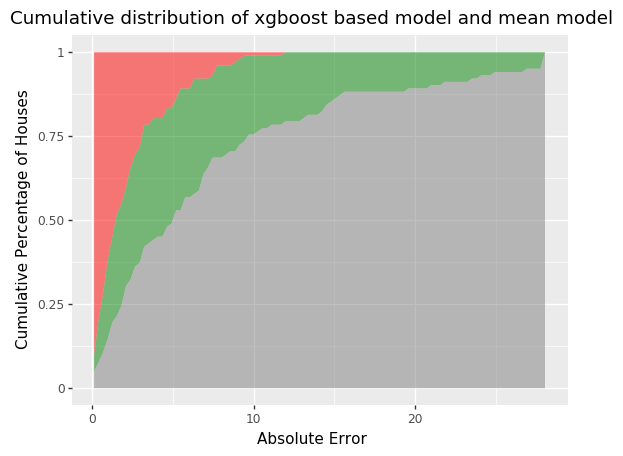

<ggplot: (307557901)>

In [8]:
df = pd.melt(test[['mean_model_error', 'xgboost_model_error']].abs(), value_vars=['mean_model_error', 'xgboost_model_error'])
meanCount, binEdges1 = np.histogram(test['mean_model_error'].abs(), bins=100, range=[0, np.max(df.value)])
meanCumSum = meanCount.cumsum()/float(test.shape[0])

xgboostCount, binEdges2 = np.histogram(test['xgboost_model_error'].abs(), bins=100, range=[0, np.max(df.value)])
xgboostCumSum = xgboostCount.cumsum()/float(test.shape[0])

assert np.array_equal(binEdges1, binEdges2), "Bins are different"

df = pd.DataFrame({
    'absolute_error': binEdges1[:-1] + np.diff(binEdges1)/2.0,
    'mean_cumsum': meanCumSum,
    'xgboost_cumsum': xgboostCumSum
})

(
    ggplot(df, aes(x='absolute_error'))
    + geom_ribbon(aes(ymin='mean_cumsum', ymax='xgboost_cumsum'), fill='green', alpha=0.5)
    + geom_ribbon(aes(ymin='xgboost_cumsum', ymax=1), fill='red', alpha=0.5)
    + geom_ribbon(aes(ymin=0, ymax='mean_cumsum'), fill='grey', alpha=0.5)
    + xlab("Absolute Error")
    + ylab("Cumulative Percentage of Houses")
    + ggtitle("Cumulative distribution of xgboost based model and mean model")
)


The advantage of AAC over MAE is that it takes into account the complete distribution of the absolute error and further quantify how far is a given model from the ideal model. However, as an evaluation metric, it's missing many desirable characteristics. Some of the key concerns are:

1. AAC is inversely related to model quality. As AAC increases, model quality deteriorates and vice-versa and thereby is counter-intuitive. 

2. AAC is bounded only on one side.  IOA can range from 0 to infinity. As the model quality deteriorates and AAC increases to infinite. A good metric should be bounded between 0 and 1 or -1 to 1 to make it easy to interpret. 

3. AAC is not differentiable. AAC uses "absolute" function, which is non-differentiable. For optimization, it is often desirable to have a function that is differentiable. 
                                                                                                                                          
Let's focus on the first problem. One simple fix to address the inverse relationship problem is to consider the area under the curve (AUC). In the above plot, AUC for the XGboost based model is the sum of the green and the grey regions. Conceptually, AUC represents improvement made by a given model as compared to the worst model. Theoretically, the worst model has an infinite absolute error for 100% test cases. Thus, the cumulative distribution plot of it overlaps with the x-axis and extends to infinity. Using the worst model, however, complicates computing AUC and hence we need some other baseline model. The "mean model," one of the three models that we trained, is another good baseline. It uses no additional features other than the target variable itself and, in practice, is the worst model that the machine can learn. Let's redefine AUC as $AUC_{mean}$ to represent the area the cumulative distribution plot of a given model and the mean model. In the above plot, the green region represents $AUC_{mean}$ for the XGboost based model. Mathematically, we can represent $AUC_{mean}$ as 

$$ AUC_{mean}(m) =  \int_0^{1}{|\hat{y}_m-\bar{y}|} ~ \approx ~ \sum_i{|\hat{y}_m-\bar{y}|} $$

where
* m represents a given model, such as XGboost based model
* $\hat{y}_m$ represents predicted target value for a given test case
* $\bar{y}$ represents mean predicted target value.

We can also rewrite $AUC_{mean}$ in terms of AAC as shown below

$$ AUC_{mean}(m) = AAC(mean) - AAC(m) $$

where
* $AAC(mean)$ represents AAC for the mean model. 
* $AAC(m)$ represents AAC for a given model. 

$AUC_{mean}$ can range from $-\infty$ to $\infty$. It will be negative when our model is worse than the mean model and hence the cumulative plot of the given model is below the mean model. However, as discussed earlier, a bounded metric is much more easy to interpret and hence desirable. One way to bound $AUC_{mean}$ above is to normalize it by AAC(mean). That we redefine $AUC_{mean}$ as

$$ AUC_{mean}(m) = \frac{AAC(mean) - AAC(m)}{AAC(mean)} $$

or 

$$ AUC_{mean}(m) = 1 - \frac{AC(m)}{AAC(mean)} $$


Theoretically, based on the new definition, AUC_{mean} can range from $-\infty$ to 1. It is 1 when area above the curve for the given model, i.e. $AAC(m)$ is equal to 0. In that case we have an ideal model that is accurate for 100% of the test cases. $AUC_{mean}(m)$ will be zero when the model is same as the mean model. However if its worse than the mean model then it can range from anywhere 0 to $-\infty$. In pratcise, however, $AUC_{mean}(m)$ can only range from 0 to 1. If it is less than 0, then one can essentially replace the learned model with the mean model. 

One last issue with AAC is that its not deferentiable due to usage of the "absolute" function. We used the "absolute" function to make the errors additive. To fix this, we can replace the "absolute" function with the "square" function. Thus we can rewrite AUC definition as

$$ AUC_{mean}(m) = 1 - \frac{AC(m)}{AAC(mean)} \approx 1 - \frac{\sum{(y-\hat{y})^2}}{\sum{(y-\bar{y})^2}}$$

The above equation should start looking familiar. Not only we rediscovered intuition behind $R^2$ but can also visualize the metric. The below code snippet computes $R^2$ based on the idea explained above and also using sklearn library. 

In [9]:
# Manually calculating R2
print("Manually Computing R2")
print("Xgboost Model: ", 1 - np.sum((test['price'] - test['xgboost']) ** 2)/ np.square(test['price'] - test['mean']).sum())
print("Regression Model: ", 1 - np.sum(test['regression_model_error'] ** 2)/np.sum(test['mean_model_error'] ** 2))
print("Mean Model: ", 1 - np.sum(test['mean_model_error'] ** 2)/np.sum(test['mean_model_error'] ** 2))


# Using sklearn
print("\nUsing Sklearn")
from sklearn.metrics import r2_score
print("Decision Tree: ", r2_score(test['price'], test['xgboost']))
print("Regression Model: ", r2_score(test['price'], test['regression']))
print("Mean Model: ", r2_score(test['price'], test['mean']))



Manually Computing R2
Xgboost Model:  0.8948728277178886
Regression Model:  0.7041704429324553
Mean Model:  0.0

Using Sklearn
Decision Tree:  0.8830617869680325
Regression Model:  0.6709339839115636
Mean Model:  -0.11235002800380478


Note: For the mean model one might expect $R^2 = 0$. However using sklear we get non zero value. That's because sklearn is computing mean house price based on the test dataset. 

Apart from "Mean Absolute Error" and $R^2$, there are few other metrics, such as squared error, squared log error, etc., that are popularly used when evaluating a regression model. A good starting to find more about these metrics is the list of implemented metrics in `sklear` library over [here](http://scikit-learn.org/stable/modules/model_evaluation.html). 

One might also find it useful to read about adjusted $R^2$ metric. $R^2$ doesn't penalize for the number of features and is addressed by adjusted $R^2$ metric. Hopefully this chapter will now make it easy to understand some of these variants of $R^2$ and other regression metrics. 